In [15]:
import matplotlib.pyplot as plt
import napari
import numpy as np
import pyclesperanto as cle
import skimage
from matplotlib.pyplot import color_sequences

from mt.ct_utils import contact_area
from mt.utils import get_transpose_order

cle.select_device("RTX")

(OpenCL) NVIDIA GeForce RTX 4070 SUPER (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              565.90
	Device Type:                 GPU
	Compute Units:               56
	Global Memory Size:          12281 MB
	Maximum Object Size:         3070 MB
	Max Clock Frequency:         2505 MHz
	Image Support:               Yes

In [16]:
particles = np.load("../../06_Results/uCT/AD67/_particle_mask.npy")
particles = np.transpose(particles, get_transpose_order(particles, "z"))
tesselation = np.load("../../06_Results/uCT/AD67/_tesselation.npy")
tesselation = np.transpose(tesselation, get_transpose_order(tesselation, "z"))
mask = np.load("../../06_Results/uCT/AD67/_mask.npy")
mask = np.transpose(mask, get_transpose_order(mask, "z"))

mid_idx = len(particles) // 2
# 
print(particles.shape)
tess_slice = tesselation[mid_idx]
part_slice = particles[mid_idx]
mask_slice = mask[mid_idx]

(63, 890, 1115)


In [17]:
len(np.unique(particles))

786

In [18]:
viewer = napari.Viewer()
viewer.add_labels(tess_slice)
viewer.add_labels(part_slice)
viewer.add_labels(mask_slice)

<Labels layer 'mask_slice' at 0x1d15abf9d50>

In [49]:
def divide_into_grid(image,
                     cells: tuple[int, int] = (3, 3),
                     exclude_edges: bool = False):
    h, w = image.shape
    cell_h = h // cells[0]
    cell_w = w // cells[1]
    regions = []
    for i in range(cells[0]):
        for j in range(cells[1]):
            region = image[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            if exclude_edges:
                region = cle.pull(cle.exclude_labels_on_edges(region))
            regions.append(region)
    return regions

def region_cell_areas(regions):
    areas = []
    for region in regions:
        cell_areas, _ = skimage.exposure.histogram(region, channel_axis=0)
        cell_areas = np.sort(cell_areas[cell_areas > 0])[:-1]
        areas.append(cell_areas)
    return areas

def polymer_contact(regions):
    contact_pct = []
    for region in regions:
        region = region[..., np.newaxis]
        air_Al = contact_area(region, 1, 3)
        poly_Al = contact_area(region, 2, 3)
        contact_pct.append(poly_Al/(air_Al + poly_Al))
    contact_pct = np.array(contact_pct)
    return contact_pct

def get_areas_and_contact(tess_slice,
                          mask_slice,
                          regions=(3, 3),
                          exclude_edges=False):
    # get means of voronoi cell areas for regions
    cells = divide_into_grid(tess_slice, regions)
    print("Region size: ", cells[0].shape)
    areas = region_cell_areas(cells)
    mean_areas = np.array([np.mean(area)*2.5**2 for area in areas])
    mean_areas = mean_areas.reshape(*regions)

    # get polymer contact percentage for regions
    cells = divide_into_grid(mask_slice, exclude_edges=exclude_edges, cells=regions)
    contact_percent = polymer_contact(cells).reshape(*regions)
    return mean_areas, contact_percent

def visualise_region_properties(tess_slice,
                                mask_slice,
                                cells=(3, 3)):
    mean_areas, contact_percent = get_areas_and_contact(tess_slice, mask_slice, cells)

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    im = axs[0].imshow(mean_areas, cmap="inferno")
    axs[0].set_title("Mean area of cells in regions im um^2")
    fig.colorbar(im, ax=axs[0])
    im = axs[1].imshow(contact_percent, cmap="inferno")
    axs[1].set_title("Polymer contact percentage")
    fig.colorbar(im, ax=axs[1])
    plt.show()
    return mean_areas, contact_percent



In [44]:
region = divide_into_grid(tess_slice, (3, 3))

890 296


730 121


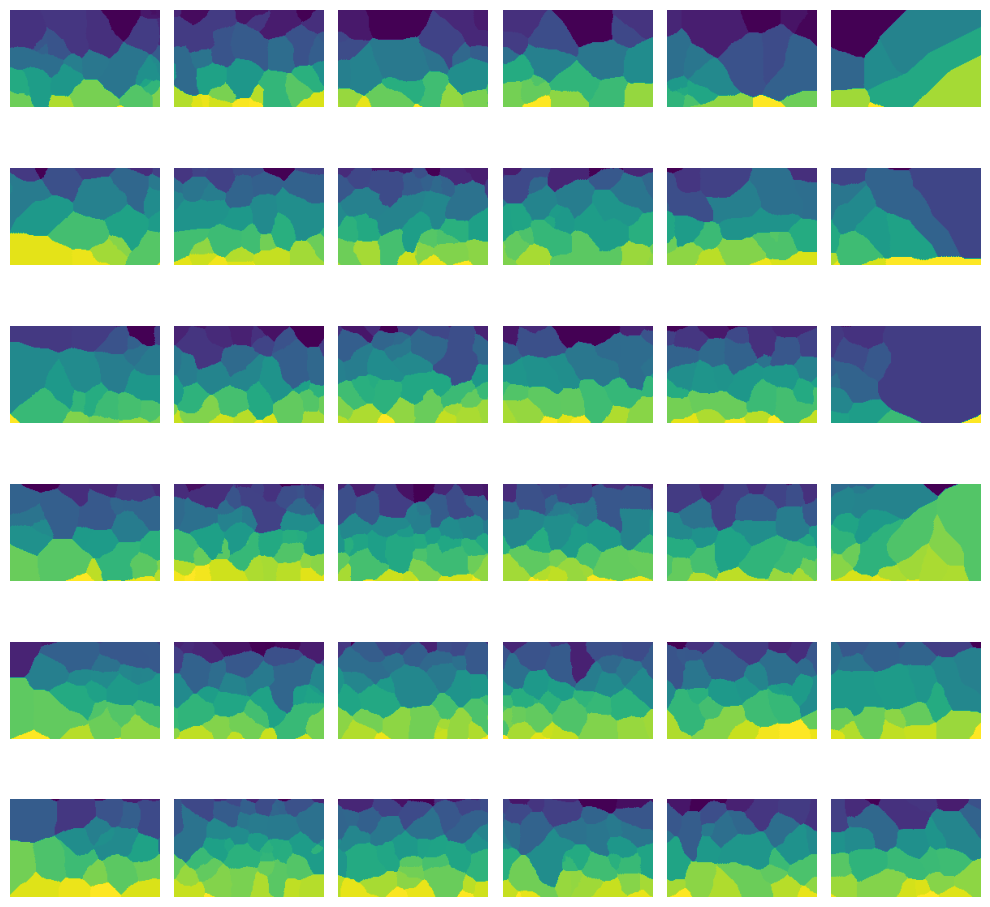

In [48]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10))
regions = divide_into_grid(tess_slice[80:-80, :], (6, 6))
for i in range(6):
    for j in range(6):
        axs[i, j].imshow(regions[i*6 + j])
        axs[i, j].axis("off")
fig.tight_layout()

3
Region size:  (296, 371)


C:\Users\malte\anaconda3\envs\thesis\Lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


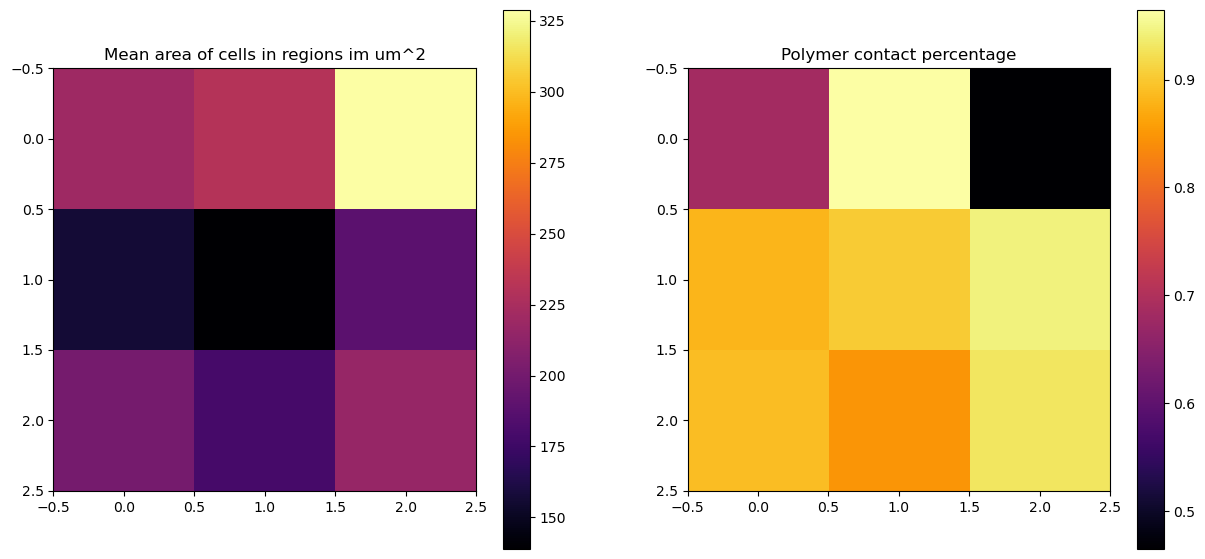

6
Region size:  (148, 185)


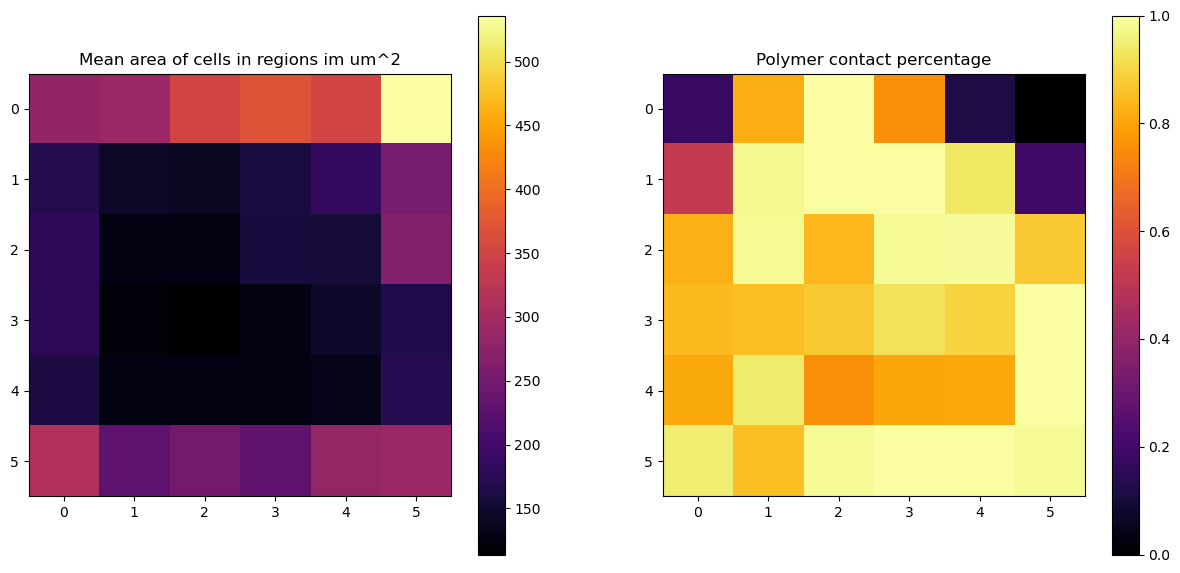

9
Region size:  (98, 123)


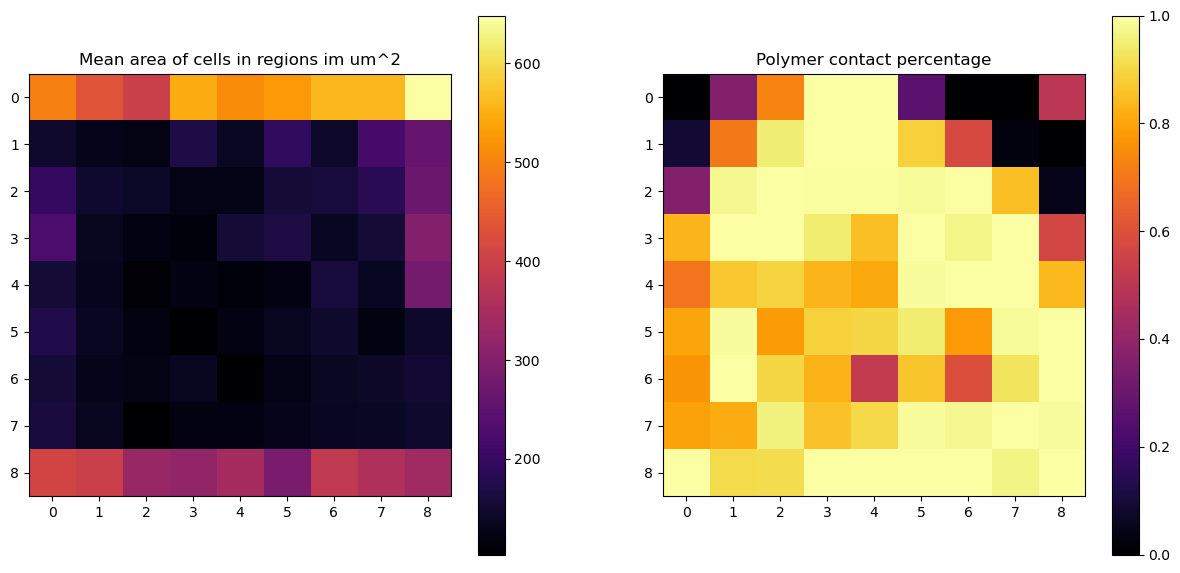

In [50]:
area_list = []
contact_list = []
for ii in [3, 6, 9]:
    print(ii)
    areas, contact = visualise_region_properties(tess_slice, mask_slice, (ii, ii))
    area_list.append(areas)
    contact_list.append(contact)

Text(0, 0.5, 'Polymer contact percentage')

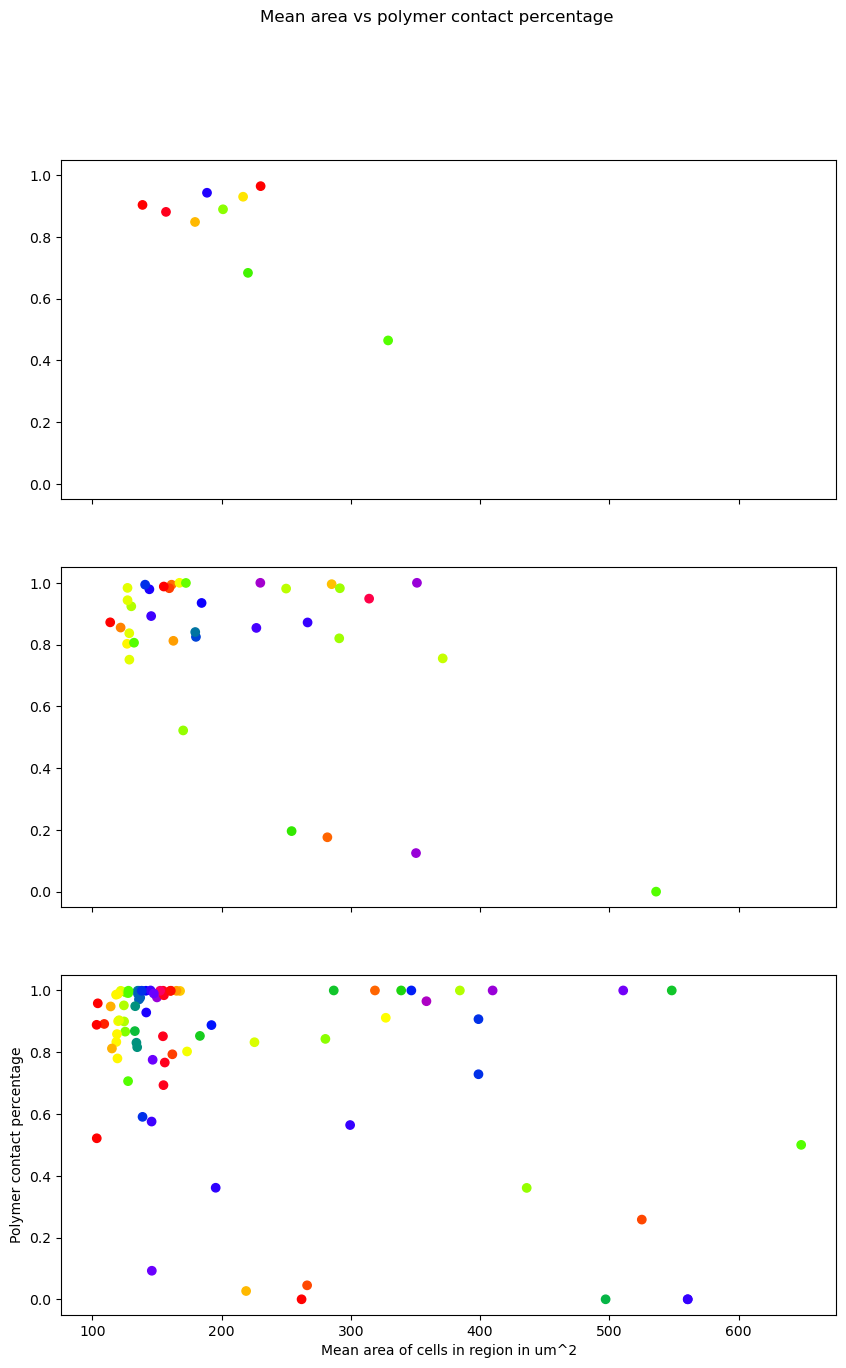

In [56]:
# areas, contact = np.sort(areas.flatten()), np.sort(contact.flatten())
fig, axs = plt.subplots(3, figsize=(10, 15), sharex=True, sharey=True)
for ii in range(3):
    areas, contact = area_list[ii], contact_list[ii]
    axs[ii].scatter(areas.ravel(), contact.ravel(), c=areas.ravel(), cmap="prism")
plt.suptitle("Mean area vs polymer contact percentage")
plt.xlabel("Mean area of cells in region in um^2")
plt.ylabel("Polymer contact percentage")